In [1]:
import os
import json
import random

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image

import cv2

from sklearn.experimental import enable_halving_search_cv

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



from sklearn.model_selection import (train_test_split,cross_val_predict,cross_val_score
                                     ,RandomizedSearchCV,GridSearchCV,HalvingGridSearchCV,HalvingRandomSearchCV)
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.metrics import (f1_score,precision_recall_curve,precision_score
                             ,recall_score,ConfusionMatrixDisplay,accuracy_score)

from plyer import notification
from discord import SyncWebhook


import imgaug.augmenters as imaug

import tensorflow as tf


In [2]:
def alert(data="Execution Completed"):
    notification.notify(
    title = "Python",
    message = data,
    timeout = 10
    )
    

In [3]:
test_dir = "dataset/test/"
train_dir = "dataset/train/"

classes = os.listdir(train_dir)
classes

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

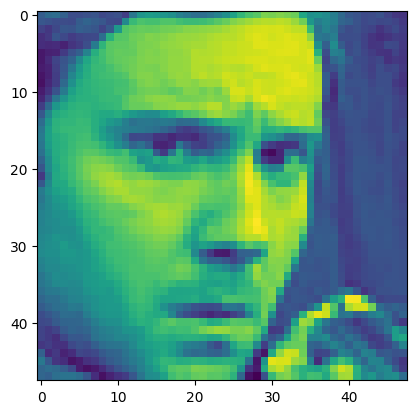

In [4]:
data = np.asarray(Image.open(r"dataset\train\angry\im0.png"))
# plt.imshow(data)
plt.imshow(data)


In [5]:
def augument(data):
    final_img = []
    
    final_img.append(data)
    
    augmentation = imaug.Sequential([
        imaug.Affine(translate_percent={"x": (0.45, -0.45), "y": (-0.2, 0.2)},scale=(0.8,0.8)),
    ])
    a = augmentation(images = [data])
    final_img.append(a[0])
    
    augmentation = imaug.Sequential([
        imaug.Affine(scale=(0.8, 0.8),rotate=(45,45)),
    ])
    a = augmentation(images = [data])
    final_img.append(a[0])

    augmentation = imaug.Sequential([
        imaug.Affine(scale=(0.8, 0.8),rotate=(45,45)),
        imaug.Fliplr(1)
    ])
    a = augmentation(images = [data])
    final_img.append(a[0])
    
    # augmentation = imaug.Sequential([
    #     imaug.Affine(scale=(0.8, 0.8),rotate=(45,45)),
    #     imaug.Fliplr(1),
    #     imaug.Flipud(1)
        
    # ])
    # a = augmentation(images = [data])
    # final_img.append(a[0])
    
    # augmentation = imaug.Sequential([
    #     imaug.Affine(scale=(0.8, 0.8),rotate=(45,45)),
    #     imaug.Fliplr(0),
    #     imaug.Flipud(1)
        
    # ])
    # a = augmentation(images = [data])
    # final_img.append(a[0])
    
    augmentation = imaug.Sequential([
        imaug.Affine(scale=(0.8, 0.8)),
        
    ])
    a = augmentation(images = [data])
    final_img.append(a[0])
    
    
    # augmentation = imaug.Sequential([
    #     imaug.Affine(scale=(0.8, 0.8)),
    #     imaug.Flipud(1),
    #     imaug.Fliplr(1),
    # ])
    # a = augmentation(images = [data])
    # final_img.append(a[0])
        
    
    return final_img

In [6]:
x_train = []
y_train = []

encoded_classes = [i for i in range(len(classes))]


count = 0
inc_count = 0

for i in range(len(classes)):
    datalist = os.listdir(train_dir+classes[i])
    
    if (len(datalist) > 500):
        rand = random.sample(range(0,len(datalist)),500)
        
    for j in datalist:
        data = np.asarray(Image.open(train_dir+classes[i]+"/"+j))
        if (i==1):   
            aug_data = augument(data)
            for k in aug_data:
                data_norm = cv2.normalize(k,None,0,1,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
                x_train.append(data_norm)
                y_train.append(encoded_classes[i])
                count += 1
                
        elif (i in [0,2]):
            if (inc_count not in rand):
                data_norm = cv2.normalize(data,None,0,1,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
                x_train.append(data_norm)
                y_train.append(encoded_classes[i])
                count += 1
                inc_count += 1
                
            else:
                augmentation = imaug.Sequential([
                    imaug.Affine(scale=(0.8, 0.8)),
                    
                ])
                aug_data = augmentation(images = [data])
                
                for k in aug_data:
                    data_norm = cv2.normalize(k,None,0,1,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
                    x_train.append(data_norm)
                    y_train.append(encoded_classes[i])
                    count += 1
                    inc_count += 1      
                
        else:
            data_norm = cv2.normalize(data,None,0,1,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
            x_train.append(data_norm)
            y_train.append(encoded_classes[i])
            count += 1
            
            
    print({classes[i]: count})
    count = 0
    inc_count = 0

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)


{'angry': 3995}
{'disgusted': 2180}
{'fearful': 4097}
{'happy': 7215}
{'neutral': 4965}
{'sad': 4830}
{'surprised': 3171}
(30453, 48, 48)


In [7]:
def image_show(img):
    data = img
    plt.imshow(cv2.cvtColor(data,cv2.COLOR_BGR2RGB))
    plt.show()

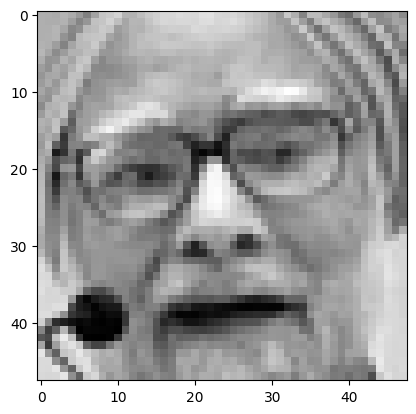

1275


In [8]:
image_show(x_train[1])
print(x_train[0].argmax())

In [9]:
x_train.shape

(30453, 48, 48)

1


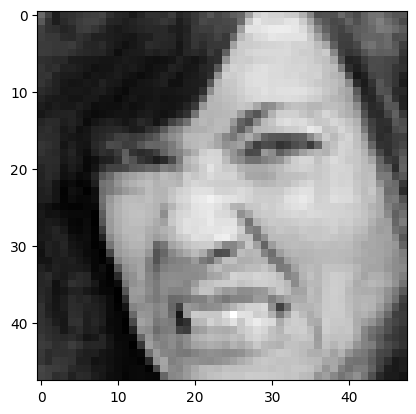

In [10]:
print(y_train[4000])
image_show(x_train[4000])

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.1,random_state=30)

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27407, 48, 48)
(27407,)
(3046, 48, 48)
(3046,)


In [245]:
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

In [246]:
x_train_scaled[0]


array([0.27374563, 0.31293023, 0.35402533, ..., 0.4272392 , 0.3837841 ,
       0.44937944], dtype=float32)

In [247]:
# ord_encdr = OrdinalEncoder()
# y_train_encoded = ord_encdr.fit_transform(y_train.reshape(-1,1))

In [248]:
# ord_encdr.categories_

In [249]:
rnd_model = RandomForestClassifier(max_depth= 15,
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_estimators= 500,
 verbose=3,
 n_jobs=4)



In [250]:
# hyperF = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [100, 500, 1000],
#            'seed' : [20]}



# gridF = HalvingRandomSearchCV(rnd_model, hyperF,factor=2,random_state=42, cv = 3, verbose = 3, 
#                       n_jobs = -1)
# bestF = gridF.fit(x_train_scaled, y_train)

In [251]:
# with open("parameter.json","w") as f:
#     json.dump(gridF.best_params_,f)
    


# webhook = SyncWebhook.from_url("https://discord.com/api/webhooks/1063122746835472466/QWFwQkRFXRtRLa0j21nvMl2D7qQooBs3OiAun2SEwlwSFf0UegILx4SXKxKQ_Gq7FjEr")
# webhook.send(f"```{gridF.best_params_}```")
    
# # os.system("shutdown /s /t 1")

In [252]:
# gridF.best_params_

In [253]:
pred = cross_val_predict(rnd_model,x_train_scaled,y_train,cv=3)
print(pred[:3])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   53.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n

[4 3 0]


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


In [254]:
pres_score = precision_score(y_train,pred,average="micro")
print(f"precision_score - {pres_score}")

precision_score - 0.46382311088408074


In [255]:
webhook = SyncWebhook.from_url("https://discord.com/api/webhooks/1063122746835472466/QWFwQkRFXRtRLa0j21nvMl2D7qQooBs3OiAun2SEwlwSFf0UegILx4SXKxKQ_Gq7FjEr")
webhook.send(f"Execution Complete => Precision_score - {pres_score}")

alert(f"Execution Complete => Precision_score - {pres_score}")

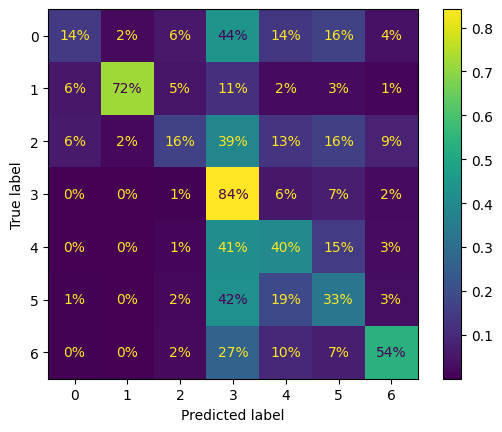

       0          1        2      3        4    5          6
0  angry  disgusted  fearful  happy  neutral  sad  surprised


In [256]:
ConfusionMatrixDisplay.from_predictions(y_train,pred,values_format='.0%',normalize='true')
plt.show()
print(pd.DataFrame([classes]))

In [257]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [262]:
for i in range(len(classes)):
    datalist = os.listdir(train_dir+classes[i])
    for j in datalist:
        count += 1
    # print({classes[i]: count})
    # count = 0
    
print(count)
        

28709


In [259]:
# augmentation = imaug.Sequential([
#     # 1. Flip
#     imaug.Fliplr(1),
#     imaug.Flipud(1),
#     # 2. Affine
#     imaug.Affine(scale=(0.8, 0.8),rotate=(45,45)),
#     # 3. Multiply
#     imaug.RemoveSaturation(1),
#     imaug.Multiply((1,1)),
#     # 4. Linearcontrast
#     imaug.LinearContrast((0.6, 1.4)),
#     # Perform methods below only sometimes
#     imaug.Sometimes(0.5,
#         # 5. GaussianBlur
#         imaug.GaussianBlur((0.0, 3.0))
#         )
# ])

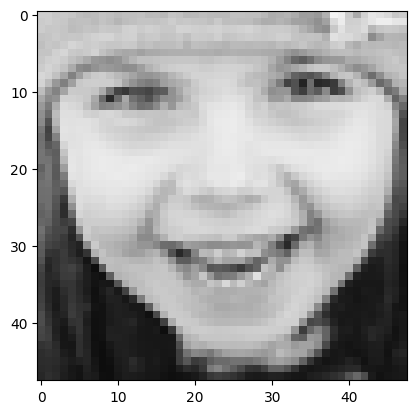

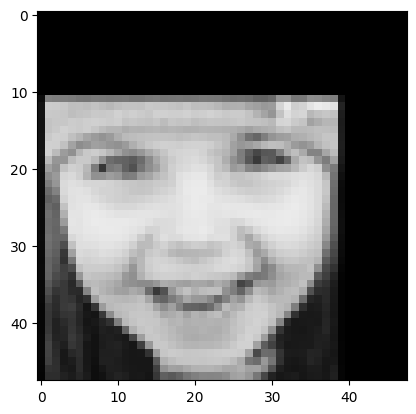

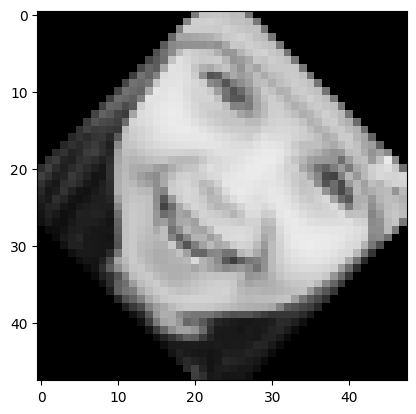

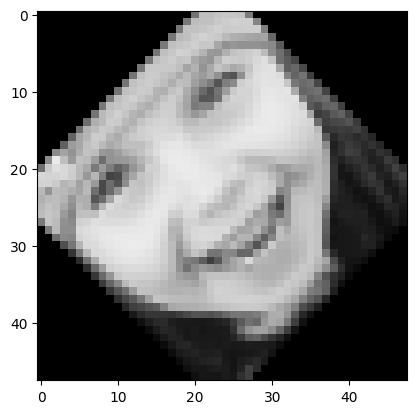

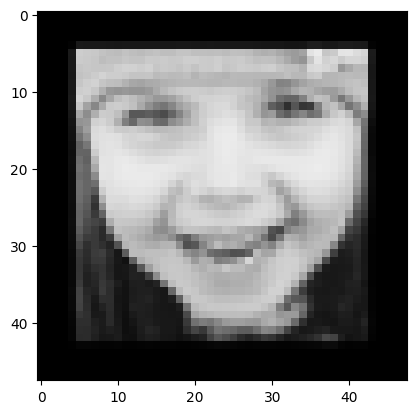

In [260]:
temp_img = np.asarray(Image.open(r"dataset\test\happy\im1710.png"))

a = augument(temp_img)

for i in a:
    image_show(i)

In [12]:
print(classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [85]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [48,48]),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(400,activation="elu",kernel_initializer='he_normal'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300,activation="elu",kernel_initializer='he_normal'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(200,activation="elu",kernel_initializer='he_normal'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7,activation="softmax")
])

In [86]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense_25 (Dense)            (None, 400)               922000    
                                                                 
 dense_26 (Dense)            (None, 300)               120300    
                                                                 
 dense_27 (Dense)            (None, 200)               60200     
                                                                 
 dense_28 (Dense)            (None, 7)                 1407      
                                                                 
Total params: 1,103,907
Trainable params: 1,103,907
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [88]:
history = model.fit(x_train,y_train,epochs=30,validation_split=0.05)

Epoch 1/30
814/814 [==============================] - 6s 7ms/step - loss: 1.7103 - accuracy: 0.3067 - val_loss: 1.6226 - val_accuracy: 0.3465
Epoch 2/30
814/814 [==============================] - 5s 6ms/step - loss: 1.5971 - accuracy: 0.3675 - val_loss: 1.5436 - val_accuracy: 0.3902
Epoch 3/30
814/814 [==============================] - 5s 6ms/step - loss: 1.5641 - accuracy: 0.3844 - val_loss: 1.5798 - val_accuracy: 0.3640
Epoch 4/30
814/814 [==============================] - 5s 6ms/step - loss: 1.5422 - accuracy: 0.3926 - val_loss: 1.5191 - val_accuracy: 0.4055
Epoch 5/30
814/814 [==============================] - 5s 6ms/step - loss: 1.5239 - accuracy: 0.4007 - val_loss: 1.5102 - val_accuracy: 0.4092
Epoch 6/30
814/814 [==============================] - 5s 6ms/step - loss: 1.5118 - accuracy: 0.4049 - val_loss: 1.4912 - val_accuracy: 0.4121
Epoch 7/30
814/814 [==============================] - 5s 6ms/step - loss: 1.4988 - accuracy: 0.4104 - val_loss: 1.4964 - val_accuracy: 0.4158
Epoch 

In [89]:
l = [1,2,3]
print(l[1:2])

[2]


In [90]:
classes

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

1/1 [==============================] - 0s 126ms/step
[[0.15007769 0.02166927 0.12744309 0.05021648 0.46059433 0.12363095
  0.06636816]]
1/1 [==============================] - 0s 42ms/step
neutral
angry


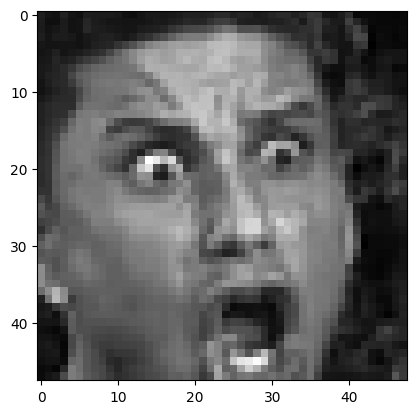

In [91]:
inp = 1000

print(model.predict(x_test[inp:inp+1]))
print(classes[model.predict(x_test[inp:inp+1])[0].argmax()])
print(classes[y_test[inp]])
image_show(x_test[inp])


In [92]:
predkt = model.predict(x_train)

857/857 [==============================] - 2s 3ms/step


In [93]:
final_pred = []
for i in predkt:
    final_pred.append(i.argmax())
    
print(final_pred[:10])


[4, 4, 0, 3, 1, 0, 3, 6, 0, 5]


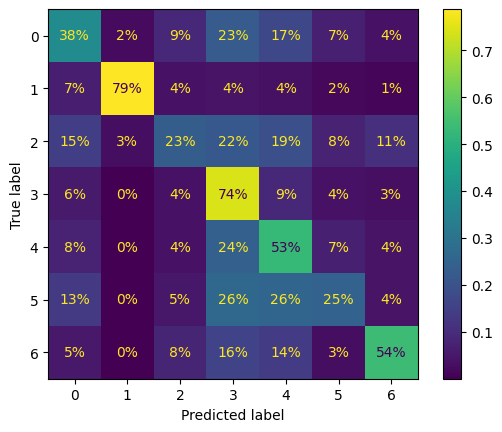

       0          1        2      3        4    5          6
0  angry  disgusted  fearful  happy  neutral  sad  surprised


In [94]:
ConfusionMatrixDisplay.from_predictions(y_train,np.array(final_pred),values_format='.0%',normalize='true')
plt.show()
print(pd.DataFrame([classes]))